### 作業
請嘗試使用 flip (左右翻轉) 來做 augmentation 以降低人臉關鍵點檢測的 loss

Note: 圖像 flip 之後，groundtruth 的關鍵點也要跟著 flip 哦




### 範例
接下來的程式碼會示範如何定義一個簡單的 CNN model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 使用 colab 環境的同學請執行以下程式碼
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# print(tf.__version__)

# import os
# from google.colab import drive 
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob，
# %cd 'gdrive/My Drive'
# os.system("mkdir cupoy_cv_part4") # 可以自己改路徑
# %cd cupoy_cv_part4 # 可以自己改路徑

In [2]:
# 讀取資料集以及做前處理的函數
def load_data(dirname):
    # 讀取 csv 文件
    data = pd.read_csv(dirname)
    # 過濾有缺失值的 row
    data = data.dropna()

    # 將圖片像素值讀取為 numpy array 的形態
    data['Image'] = data['Image'].apply(lambda img: np.fromstring(img, sep=' ')).values 

    # 單獨把圖像 array 抽取出來
    imgs = np.vstack(data['Image'].values)/255
    # reshape 為 96 x 96
    imgs = imgs.reshape(data.shape[0], 96, 96)
    # 轉換為 float
    imgs = imgs.astype(np.float32)
    
    # 提取坐標的部分
    points = data[data.columns[:-1]].values

    # 轉換為 float
    points = points.astype(np.float32)

    # normalize 坐標值到 [-0.5, 0.5]
    points = points/96 - 0.5
    
    return imgs, points

In [3]:
# 讀取資料
imgs_train, points_train = load_data(dirname = 'training.csv')
print("圖像資料:", imgs_train.shape, "\n關鍵點資料:", points_train.shape)

圖像資料: (2140, 96, 96) 
關鍵點資料: (2140, 30)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Using TensorFlow backend.


In [5]:
# 回傳定義好的 model 的函數
def get_model():
    # 定義人臉關鍵點檢測網路
    model = Sequential()

    # 定義神經網路的輸入
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(96, 96, 1)))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # 最後輸出 30 維的向量，也就是 15 個關鍵點的值
    model.add(Dense(30))
    return model

In [6]:
#model = get_model()
# 配置 loss funtion 和 optimizer
#model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
# 印出網路結構
#model.summary()

In [8]:
#from keras.callbacks import ModelCheckpoint, History
# model checkpoint 
#checkpoint = ModelCheckpoint('best_weights.h5', verbose=1, save_best_only=True)
#hist = History()

In [9]:
# training the model
#hist_model = model.fit(imgs_train.reshape(-1, 96, 96, 1), 
#                       points_train, 
#                       validation_split=0.2, batch_size=64, callbacks=[checkpoint, hist],
#                       shuffle=True, epochs=150, verbose=1)
# save the model weights
#model.save_weights('weights.h5')
# save the model
#model.save('model.h5')

In [10]:
# loss 值的圖
#plt.title('Optimizer : Adam', fontsize=10)
#plt.ylabel('Loss', fontsize=16)
#plt.plot(hist_model.history['loss'], color='b', label='Training Loss')
#plt.plot(hist_model.history['val_loss'], color='r', label='Validation Loss')
#plt.legend(loc='upper right')

### 觀察 model 在 testing 上的結果

In [11]:
# 讀取測試資料集
#imgs_test, _ = load_data(dirname = 'test.csv')

In [12]:
# 在灰階圖像上畫關鍵點的函數
#def plot_keypoints(img, points):
#    plt.imshow(img, cmap='gray')
#    for i in range(0,30,2):
#        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

In [13]:
#fig = plt.figure(figsize=(15,15))
# 在測試集圖片上用剛剛訓練好的模型做關鍵點的預測
#points_test = model.predict(imgs_test.reshape(imgs_test.shape[0], 96, 96, 1))

#for i in range(16):
#    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
#    plot_keypoints(imgs_test[i], np.squeeze(points_test[i]))

目前為止，大致可以觀察到，直接使用簡單的模型以及訓練方式在這組數據上應該可以在訓練集和測試集上都得到一個還不錯的結果，說明這組資料其實不會很難。

In [14]:
model_with_augment = get_model()
model_with_augment.compile(loss='mean_squared_error', optimizer='adam')

In [15]:
# 實現圖片以及關機點 label 做左右翻轉的函數
# Your code

def augment_data(img, points):
    rows, cols = img.shape
    new_img = np.copy(img)
    
    # 翻轉圖片
    for i in range(96):
        for j in range(48):
            temp = img[i][j]
            new_img[i][j] = img[i][cols-j-1]
            new_img[i][cols-j-1] = temp
            
    # 翻轉關鍵點 label
    new_points = np.copy(points)
    for i in range(0,30,2):
        new_points[i] = -points[i]
    
    # 調整對稱的 label
    new_points_temp = np.copy(new_points)
    new_points[0:2] = new_points_temp[2:4]
    new_points[2:4] = new_points_temp[0:2]
    new_points[4:6] = new_points_temp[8:10]
    new_points[6:8] = new_points_temp[10:12]
    new_points[8:10] = new_points_temp[4:6]
    new_points[10:12] = new_points_temp[6:8]
    new_points[12:14] = new_points_temp[16:18]
    new_points[14:16] = new_points_temp[18:20]
    new_points[16:18] = new_points_temp[12:14]
    new_points[18:20] = new_points_temp[14:16]
    new_points[22:24] = new_points_temp[24:26]
    new_points[24:26] = new_points_temp[22:24]
        
    return new_img, new_points

In [16]:
# 在灰階圖像上畫關鍵點的函數
def plot_keypoints(img, points):
    plt.imshow(img, cmap='gray')
    for i in range(0,30,2):
        plt.scatter((points[i] + 0.5)*96, (points[i+1]+0.5)*96, color='red')

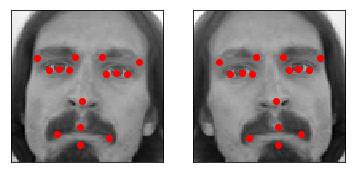

In [17]:
flip_img, flip_points = augment_data(imgs_train[0], points_train[0])

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
plot_keypoints(imgs_train[0], points_train[0]) # 原來的圖片
ax = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
plot_keypoints(flip_img, flip_points) # 翻轉後的圖片

In [18]:
# 創建 list
aug_imgs_train = []
aug_points_train = []

# 對所有原始資料做 augmentation
for i in range(imgs_train.shape[0]):
    # 做左右翻轉
    aug_img, aug_point = augment_data(imgs_train[i], points_train[i])
    
    # append 原始資料
    aug_imgs_train.append(imgs_train[i])
    aug_points_train.append(points_train[i]) 
    
    # append 做過 augmentation 後的資料
    aug_imgs_train.append(aug_img)
    aug_points_train.append(aug_point) 

# convert to numpy
aug_imgs_train = np.array(aug_imgs_train)   
aug_points_train = np.copy(aug_points_train)

print(aug_imgs_train.shape)
print(aug_points_train.shape)

(4280, 96, 96)
(4280, 30)


In [19]:
from keras.callbacks import ModelCheckpoint, History

# model checkpoint 
checkpoint_aug = ModelCheckpoint('best_weights_augment.h5', verbose=1, save_best_only=True)
hist = History()

# training the model
hist_model_aug = model_with_augment.fit(aug_imgs_train.reshape(aug_imgs_train.shape[0], 96, 96, 1), aug_points_train, 
                           validation_split=0.2, batch_size=64, callbacks=[checkpoint_aug, hist],
                           shuffle=True, epochs=150, verbose=1)

Train on 3424 samples, validate on 856 samples
Epoch 1/150
3424/3424 [==============================] - 3s 888us/step - loss: 0.0045 - val_loss: 0.0021

Epoch 00001: val_loss improved from inf to 0.00207, saving model to best_weights_augment.h5
Epoch 2/150
3424/3424 [==============================] - 1s 236us/step - loss: 0.0013 - val_loss: 0.0019

Epoch 00002: val_loss improved from 0.00207 to 0.00187, saving model to best_weights_augment.h5
Epoch 3/150
3424/3424 [==============================] - 1s 235us/step - loss: 0.0011 - val_loss: 0.0019

Epoch 00003: val_loss improved from 0.00187 to 0.00186, saving model to best_weights_augment.h5
Epoch 4/150
3424/3424 [==============================] - 1s 236us/step - loss: 9.8614e-04 - val_loss: 0.0017

Epoch 00004: val_loss improved from 0.00186 to 0.00171, saving model to best_weights_augment.h5
Epoch 5/150
3424/3424 [==============================] - 1s 235us/step - loss: 7.8944e-04 - val_loss: 0.0016

Epoch 00005: val_loss improved from

3424/3424 [==============================] - 1s 235us/step - loss: 1.4724e-04 - val_loss: 6.0492e-04

Epoch 00045: val_loss did not improve from 0.00058
Epoch 46/150
3424/3424 [==============================] - 1s 234us/step - loss: 1.4771e-04 - val_loss: 6.1062e-04

Epoch 00046: val_loss did not improve from 0.00058
Epoch 47/150
3424/3424 [==============================] - 1s 234us/step - loss: 1.4580e-04 - val_loss: 6.4001e-04

Epoch 00047: val_loss did not improve from 0.00058
Epoch 48/150
3424/3424 [==============================] - 1s 234us/step - loss: 1.4015e-04 - val_loss: 5.9905e-04

Epoch 00048: val_loss did not improve from 0.00058
Epoch 49/150
3424/3424 [==============================] - 1s 233us/step - loss: 1.4078e-04 - val_loss: 6.0158e-04

Epoch 00049: val_loss did not improve from 0.00058
Epoch 50/150
3424/3424 [==============================] - 1s 234us/step - loss: 1.3880e-04 - val_loss: 5.7891e-04

Epoch 00050: val_loss improved from 0.00058 to 0.00058, saving model

3424/3424 [==============================] - 1s 236us/step - loss: 9.1358e-05 - val_loss: 5.9805e-04

Epoch 00093: val_loss did not improve from 0.00057
Epoch 94/150
3424/3424 [==============================] - 1s 235us/step - loss: 9.0327e-05 - val_loss: 6.0411e-04

Epoch 00094: val_loss did not improve from 0.00057
Epoch 95/150
3424/3424 [==============================] - 1s 237us/step - loss: 9.3177e-05 - val_loss: 5.9984e-04

Epoch 00095: val_loss did not improve from 0.00057
Epoch 96/150
3424/3424 [==============================] - 1s 237us/step - loss: 8.9036e-05 - val_loss: 5.9389e-04

Epoch 00096: val_loss did not improve from 0.00057
Epoch 97/150
3424/3424 [==============================] - 1s 238us/step - loss: 8.7929e-05 - val_loss: 5.9796e-04

Epoch 00097: val_loss did not improve from 0.00057
Epoch 98/150
3424/3424 [==============================] - 1s 236us/step - loss: 9.0019e-05 - val_loss: 5.8126e-04

Epoch 00098: val_loss did not improve from 0.00057
Epoch 99/150
3424

3424/3424 [==============================] - 1s 236us/step - loss: 7.5889e-05 - val_loss: 5.9429e-04

Epoch 00142: val_loss did not improve from 0.00056
Epoch 143/150
3424/3424 [==============================] - 1s 236us/step - loss: 7.4619e-05 - val_loss: 6.1717e-04

Epoch 00143: val_loss did not improve from 0.00056
Epoch 144/150
3424/3424 [==============================] - 1s 235us/step - loss: 7.7764e-05 - val_loss: 6.0948e-04

Epoch 00144: val_loss did not improve from 0.00056
Epoch 145/150
3424/3424 [==============================] - 1s 236us/step - loss: 7.6501e-05 - val_loss: 6.0604e-04

Epoch 00145: val_loss did not improve from 0.00056
Epoch 146/150
3424/3424 [==============================] - 1s 235us/step - loss: 7.6374e-05 - val_loss: 6.1070e-04

Epoch 00146: val_loss did not improve from 0.00056
Epoch 147/150
3424/3424 [==============================] - 1s 239us/step - loss: 7.4379e-05 - val_loss: 6.4644e-04

Epoch 00147: val_loss did not improve from 0.00056
Epoch 148/15

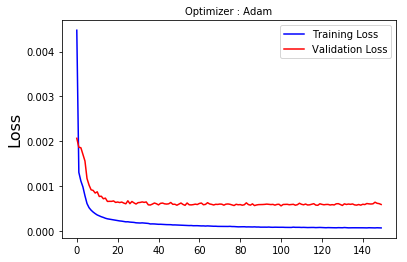

In [20]:
# loss 值的圖
plt.title('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist_model_aug.history['loss'], color='b', label='Training Loss')
plt.plot(hist_model_aug.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')